# MobileNetV2 for Classification

> Just yesterday Kaggle launched the new 'Models' tool that allows you to plug in directly to a Kaggle API for a pretrained model. This removes the necessity to rely soley on third party APIs for pretrained model usage in Kaggle projects. 

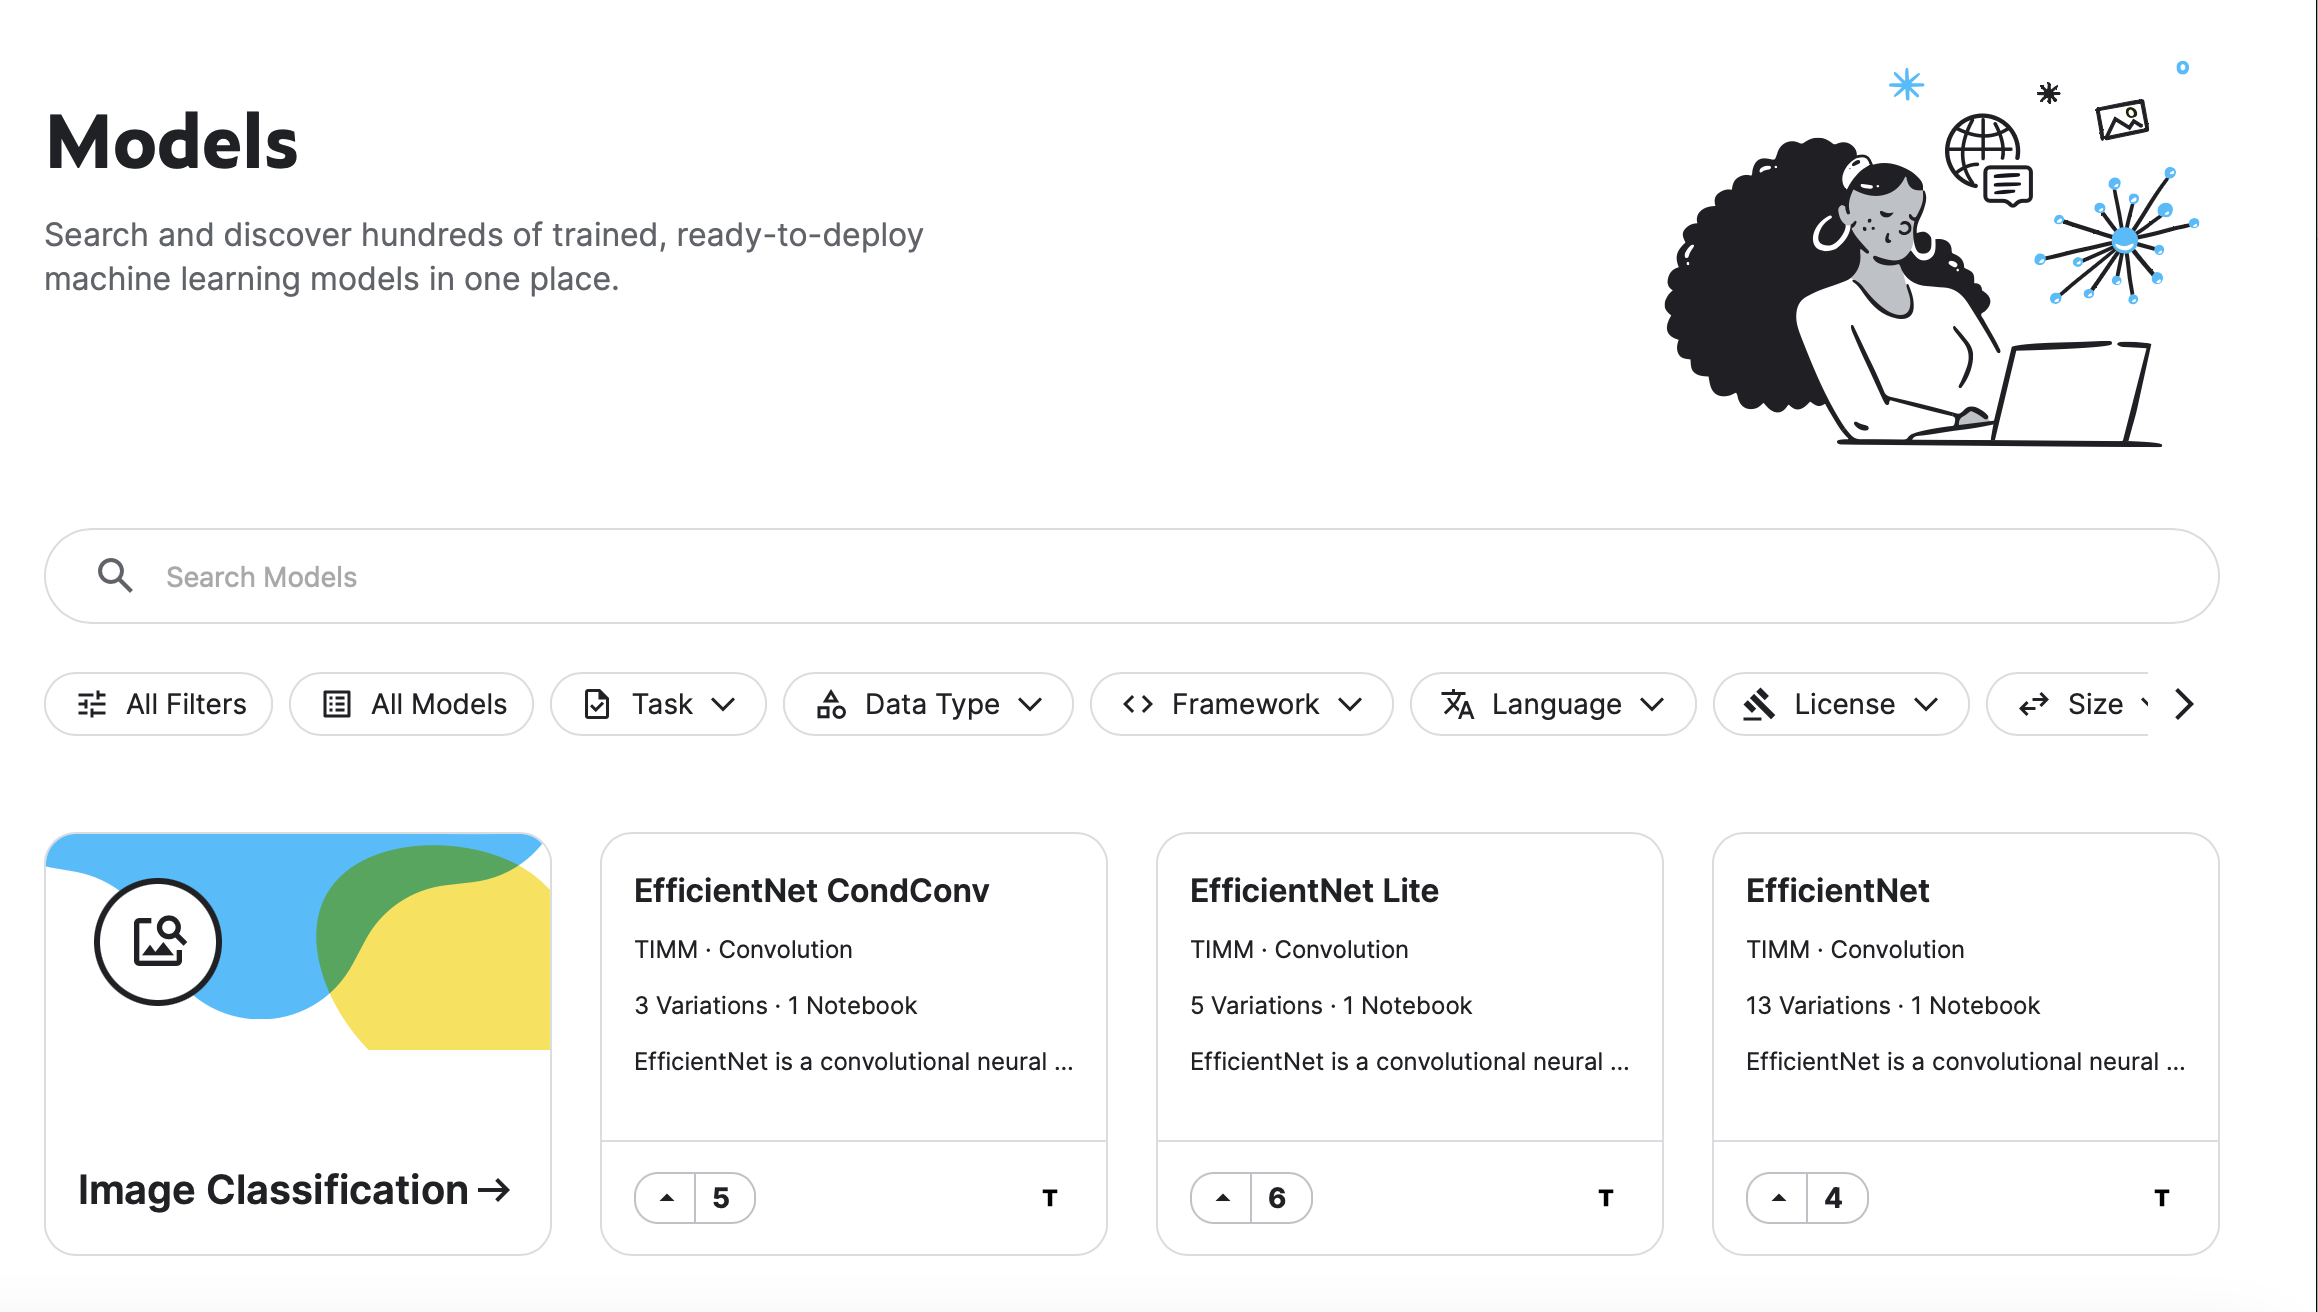

> I personally think that this is a great value add for Kaggle because it allows me to get more familiar with each model and the specific use case in the context of my own kaggle projects without having to add some sort of login or other credential from a repository like HuggingFace. (Although I still think every tool has its place). 



# Introduction

> In this notebook I am working specifically with MobileNet_V2 from Google. This is an image classification model that comes with its own large set of possible labels. There are two main use cases for this model in a Kaggle notebook, specifically:

> - Object Detection: We have an image and we want it to select the most likely objects contained in the image.

> - Transfer Learning Detection: We have a different set of objects that we want to detect, could be binary or categorical. In this case we can take the feature vector of the pretrained model and retrain it on our data. 

> Both of these scenarios are demonstrated in this notebook.

# Data

> The dataset used is called Clean/Littered Road Classification and it can be found [[here](https://www.kaggle.com/datasets/faizalkarim/cleandirty-road-classification)]. The dataset is specifically tailored for binary classification.

# MobileNet_V2

Below is a simplified outline of how MobileNet_V2 compares to other architectures. 

<div align="center">
    <img src="https://i.imgur.com/bnbquLp.png">
</div>

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from random import randint
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

# Scenario 1: Out of the Box

> The task here is to take everything as-is and look at the road pictures to see what the model is picking up. We start by adding a model to our environment. Open the tab to the right and go to the new 'Models' section. Click the 'Add Models' button. 

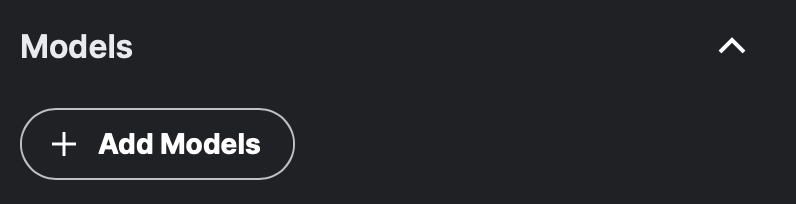

## Now search for the desired model, in our case 'MobileNet_V2'. 

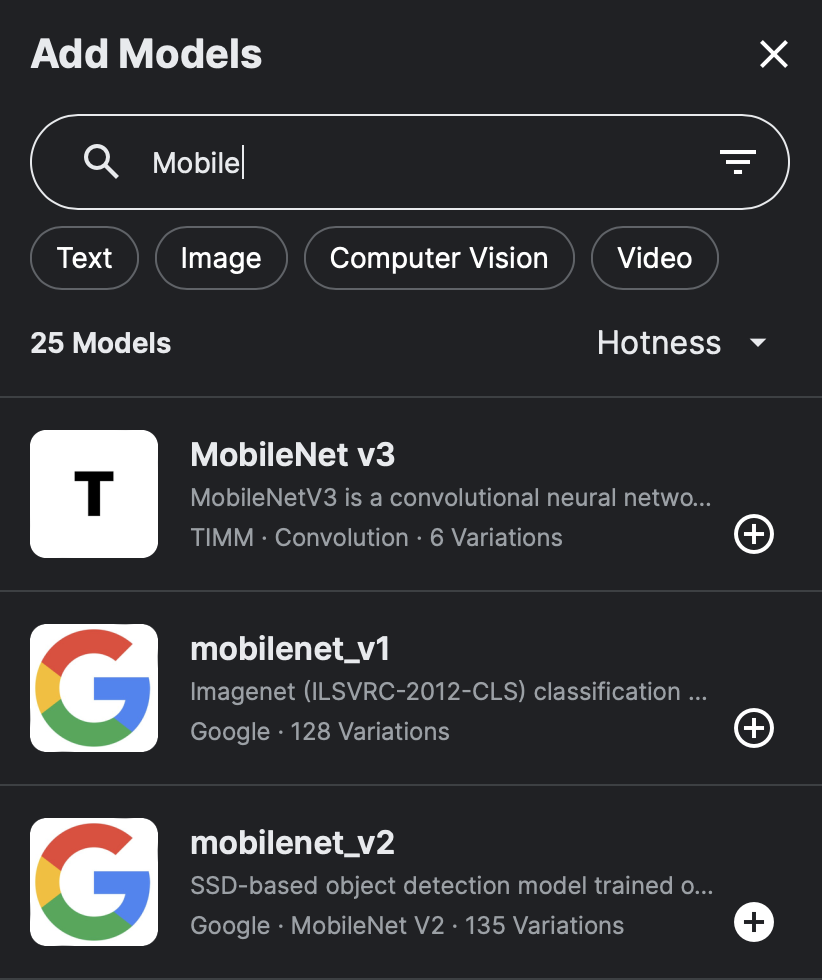

## Now click the 'plus' sign

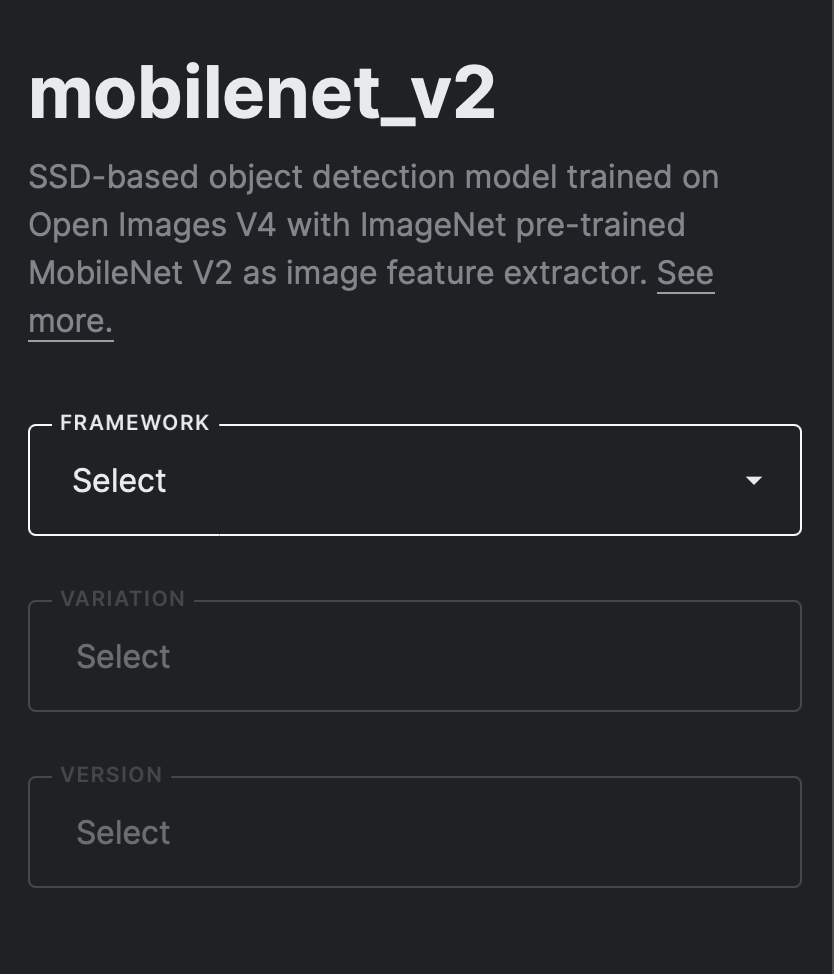

## The next part is going to depend on the model you select. The 'Model Card' section will give you a specification of what Framework, Variation, Version to use. For MobileNet_V2 we need to use Tensorflow2 as the Framework. 

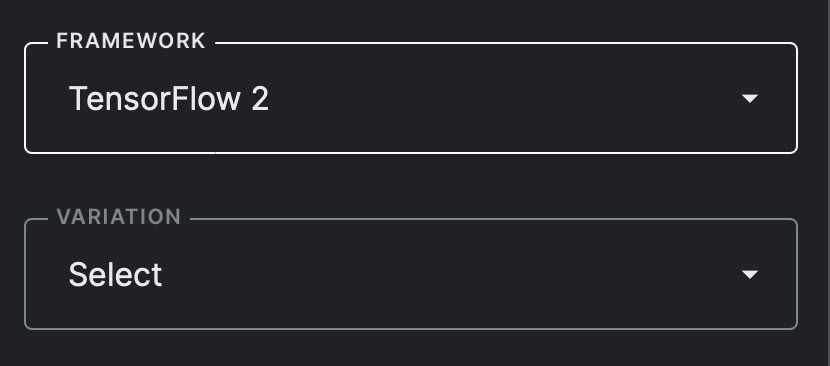

## The Variation selection depends on which scenario you are looking at. For Scenario 1, we need to choose 'Classification' because we need the model ready to classify images. Scenario 2 will need to have the feature vector component added because transfer learning in image classificaiton involves modifying the features of the model to your specific task.

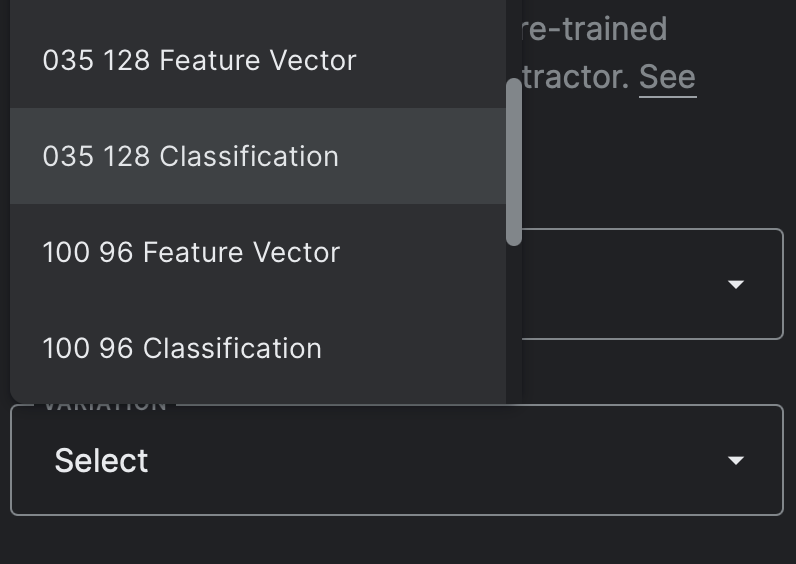

## Once you are done selecting the required dropdowns, click 'Add Model'. You should now see the following below the 'Models' section in the Notebook tab.

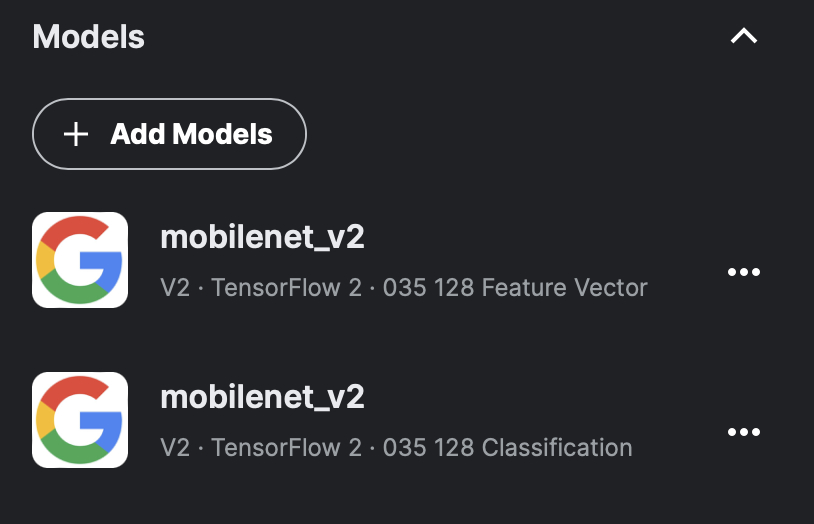

Some of the code I'm using comes directly from the notebook for this model, found [[here](https://www.kaggle.com/code/paultimothymooney/mobilenetv2-with-tensorflow)]

In [2]:
# Select an Image Classification model
model_name = "mobilenetv2-035-128"

model_handle_map = {
  "mobilenetv2-035-128": "/kaggle/input/mobilenet-v2/tensorflow2/035-128-classification/2",
}

model_image_size_map = {
  "mobilenetv2-035-128": 128,
}

model_handle = model_handle_map[model_name]

print(f"Selected model: {model_name} : {model_handle}")

Selected model: mobilenetv2-035-128 : /kaggle/input/mobilenet-v2/tensorflow2/035-128-classification/2


# Import Images and Labels

In [3]:
images_path = '/kaggle/input/cleandirty-road-classification/Images/Images/'

labels_df = pd.read_csv('/kaggle/input/cleandirty-road-classification/metadata.csv')
print('\n\nlabels dataframe: \n', labels_df.head(), '\n\n')

class_names = ('clean', 'dirty')
num_classes = len(class_names)

img_size = (128, 128, 3)

print(f'{num_classes} classes: {class_names}\nimage size: {img_size}')


labels = []
images = []
for image in labels_df.iloc:
    images.append(np.asarray(cv2.resize(cv2.imread(images_path + image[0], cv2.IMREAD_COLOR), img_size[0:2])[:, :, ::-1]))
    
    # labels will be in the form of a vector: [0, 1] or [1, 0]
    label = np.zeros(num_classes)
    label[image[1]] = 1
    labels.append(label)

labels = np.asarray(labels)
images = np.asarray(images)

print(f'\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')



labels dataframe: 
         filename  label
0    dirty_2.jpg      1
1   clean_36.jpg      0
2   clean_31.jpg      0
3   dirty_69.jpg      1
4  clean_113.jpg      0 


2 classes: ('clean', 'dirty')
image size: (128, 128, 3)

labels shape: (237, 2)
images shape: (237, 128, 128, 3)


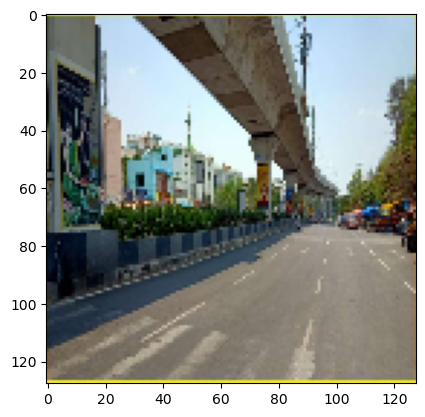

In [4]:
plt.imshow(images[1])

The first example image is this clean street above. We will plug this into the classifier to see what objects it detects.

In [5]:
#PROCESS IMAGE UTILITY
def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
  return image

In [6]:
#SHOW IMAGE UTILITY
def show_image(image, title=''):
  image_size = image.shape[1]
  w = (image_size * 6) // 320
  plt.figure(figsize=(w, w))
  plt.imshow(image[0], aspect='equal')
  plt.axis('off')
  plt.title(title)
  plt.show()

# Warmup

> It is a good idea to warm up the classifier to see if the data is flowing properly

In [7]:
demoImage = preprocess_image(images[1])
classifier = hub.load(model_handle)

input_shape = demoImage.shape
warmup_input = tf.random.uniform(input_shape, 0, 1.0)
%time warmup_logits = classifier(warmup_input).numpy()

CPU times: user 2.37 s, sys: 977 ms, total: 3.35 s
Wall time: 7.15 s


# Retrieve Pre-Defined Labels from Google

> This model was already set up with specific classes. Lets retrieve those so we can understand the context of the softmax scoring.

In [8]:
max_dynamic_size = 512
if model_name in model_image_size_map:
  image_size = model_image_size_map[model_name]
  dynamic_size = False
  print(f"Images will be converted to {image_size}x{image_size}")
else:
  dynamic_size = True
  print(f"Images will be capped to a max size of {max_dynamic_size}x{max_dynamic_size}")

labels_file = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"

#download labels and creates a maps
downloaded_file = tf.keras.utils.get_file("labels.txt", origin=labels_file)

classes = []

with open(downloaded_file) as f:
  labels = f.readlines()
  classes = [l.strip() for l in labels]

Images will be converted to 128x128
10484/10484 [==============================] - 0s 0us/step


CPU times: user 10.7 ms, sys: 0 ns, total: 10.7 ms
Wall time: 14.5 ms
(1)  840 - suspension bridge: 0.08165495097637177
(2)  707 - patio: 0.0777035504579544
(3)  836 - sundial: 0.041974782943725586
(4)  443 - bell cote: 0.04000377655029297
(5)  683 - obelisk: 0.03360451012849808


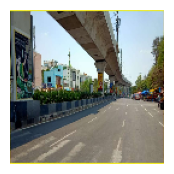

In [9]:
# Run model on image
%time probabilities = tf.nn.softmax(classifier(demoImage)).numpy()

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
np_classes = np.array(classes)

# Some models include an additional 'background' class in the predictions, so
# we must account for this when reading the class labels.
includes_background_class = probabilities.shape[1] == 1001

for i, item in enumerate(top_5):
  class_index = item if includes_background_class else item + 1
  line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
  print(line)

show_image(demoImage, '')

> Now lets see what happens when we feed it a more chaotic image, like one of the 'dirty' images that we have from our data.

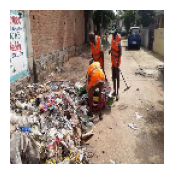

In [10]:
demoImage = preprocess_image(images[120])
show_image(demoImage, '')

CPU times: user 11.3 ms, sys: 1.87 ms, total: 13.2 ms
Wall time: 13.7 ms
(1)  666 - moped: 0.39420023560523987
(2)  492 - chain saw: 0.108576200902462
(3)  831 - stretcher: 0.09726142883300781
(4)  671 - motor scooter: 0.051123809069395065
(5)  803 - snowmobile: 0.025528358295559883


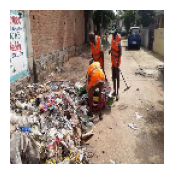

In [11]:
# Run model on image
%time probabilities = tf.nn.softmax(classifier(demoImage)).numpy()

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
np_classes = np.array(classes)

includes_background_class = probabilities.shape[1] == 1001

for i, item in enumerate(top_5):
  class_index = item if includes_background_class else item + 1
  line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
  print(line)

show_image(demoImage, '')

# Scenario 2: Transfer Learning

> This scenario is very similar in set up to the previous one, but now we have more control over how our problem is defined and what labels we can use. In the following example, I am going to take the feature vector for ImageNet and train it on a subset of the clean/dirty images. Then I will see how well it does adapting to the binary classification problem that is more relevant to this dataset.

In [12]:
model_name = "mobilenetv2-035-128"

#NOTICE HOW WE ARE USING FEATURE VECTOR FOR THIS STEP AND NOT CLASSIFIER
model_handle_map = {
  "mobilenetv2-035-128": "/kaggle/input/mobilenet-v2/tensorflow2/035-128-feature-vector/2",
}

model_image_size_map = {
  "mobilenetv2-035-128": 128,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 128)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 4

Selected model: mobilenetv2-035-128 : /kaggle/input/mobilenet-v2/tensorflow2/035-128-feature-vector/2
Input size (128, 128)


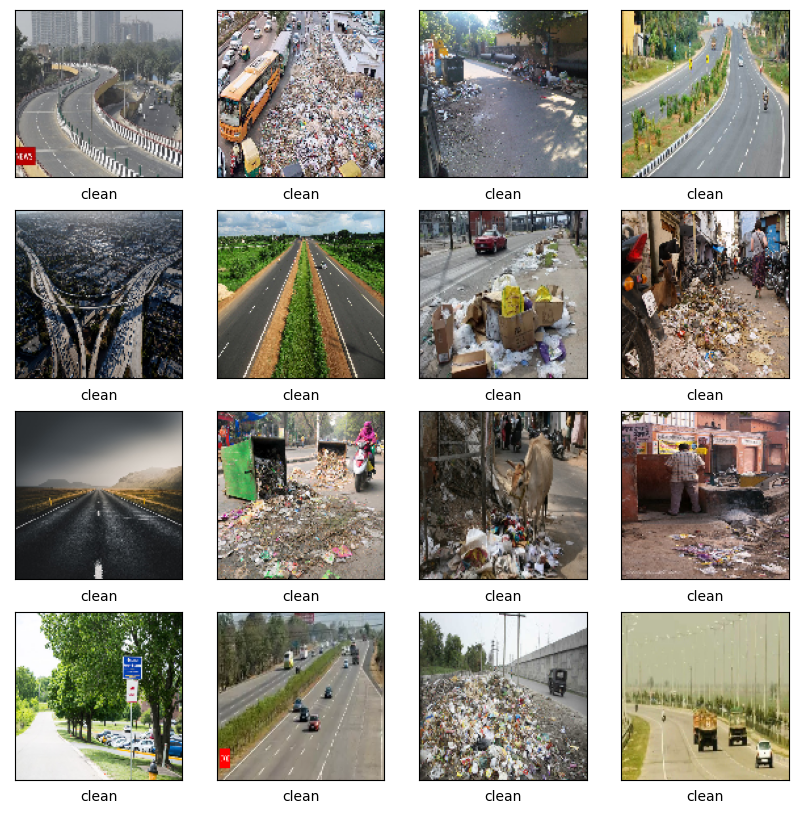

In [13]:
# Display 16 pictures from the dataset
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for x in range(4):
    for y in range(4):
        i = randint(0, len(images))
        
        axs[x][y].imshow(images[i])
        
        # delete x and y ticks and set x label as picture label
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(class_names[np.argmax(labels[i])])
        
plt.show()

In [14]:
images_path = '/kaggle/input/cleandirty-road-classification/Images/Images/'

labels_df = pd.read_csv('/kaggle/input/cleandirty-road-classification/metadata.csv')
print('\n\nlabels dataframe: \n', labels_df.head(), '\n\n')

class_names = ('clean', 'dirty')
num_classes = len(class_names)

img_size = (128, 128, 3)

print(f'{num_classes} classes: {class_names}\nimage size: {img_size}')


labels = []
images = []
for image in labels_df.iloc:
    images.append(np.asarray(cv2.resize(cv2.imread(images_path + image[0], cv2.IMREAD_COLOR), img_size[0:2])[:, :, ::-1]))
    
    # labels will be in the form of a vector: [0, 1] or [1, 0]
    label = np.zeros(num_classes)
    label[image[1]] = 1
    labels.append(label)

labels = np.asarray(labels)
images = np.asarray(images)

print(f'\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')



labels dataframe: 
         filename  label
0    dirty_2.jpg      1
1   clean_36.jpg      0
2   clean_31.jpg      0
3   dirty_69.jpg      1
4  clean_113.jpg      0 


2 classes: ('clean', 'dirty')
image size: (128, 128, 3)

labels shape: (237, 2)
images shape: (237, 128, 128, 3)


In [15]:
# DEFINE TRAIN/TEST SPLIT
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1, random_state=42)

print(f'train images shape: {X_train.shape}\ntrain labels shape: {y_train.shape}\n\nvalidation images shape: {X_val.shape}\nvalidation labels shape: {y_val.shape}\n')

train images shape: (213, 128, 128, 3)
train labels shape: (213, 2)

validation images shape: (24, 128, 128, 3)
validation labels shape: (24, 2)



In [16]:
# ImageDataGenerator for train images
train_images_generator = tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.3,
                                                                         rotation_range=15,
                                                                         zoom_range=0.3,
                                                                         vertical_flip=True, 
                                                                         horizontal_flip=True)
train_images_generator = train_images_generator.flow(X_train, y=y_train)

# ImageDataGenerator for validation images
validation_images_generator = tf.keras.preprocessing.image.ImageDataGenerator(vertical_flip=True, 
                                                                              horizontal_flip=True)
validation_images_generator = validation_images_generator.flow(X_val, y=y_val)

In [17]:
do_fine_tuning = False 

print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with /kaggle/input/mobilenet-v2/tensorflow2/035-128-feature-vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              410208    
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 412,770
Trainable params: 2,562
Non-trainable params: 410,208
_________________________________________________________________


In [18]:
# creating ModelChecpoint callback
checkpoint_callback = ModelCheckpoint('cnn_model/model{epoch:02d}')

## Compile and Train Model

In [19]:
model.compile(
  optimizer='adam', 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

train_size = X_train.shape[0]
valid_size = X_val.shape[0]
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_images_generator,
    epochs=20,
    verbose=1,
    validation_data=validation_images_generator, callbacks=[checkpoint_callback])

Epoch 1/20
7/7 [==============================] - 15s 2s/step - loss: 0.9238 - accuracy: 0.3850 - val_loss: 0.7081 - val_accuracy: 0.5000
Epoch 2/20
7/7 [==============================] - 8s 1s/step - loss: 0.7204 - accuracy: 0.5446 - val_loss: 0.6278 - val_accuracy: 0.7083
Epoch 3/20
7/7 [==============================] - 8s 1s/step - loss: 0.6808 - accuracy: 0.6103 - val_loss: 0.5205 - val_accuracy: 0.9167
Epoch 4/20
7/7 [==============================] - 9s 1s/step - loss: 0.6532 - accuracy: 0.6854 - val_loss: 0.5028 - val_accuracy: 0.8333
Epoch 5/20
7/7 [==============================] - 8s 1s/step - loss: 0.6437 - accuracy: 0.6854 - val_loss: 0.4396 - val_accuracy: 0.9167
Epoch 6/20
7/7 [==============================] - 8s 1s/step - loss: 0.5924 - accuracy: 0.7136 - val_loss: 0.4650 - val_accuracy: 0.8750
Epoch 7/20
7/7 [==============================] - 8s 1s/step - loss: 0.5890 - accuracy: 0.7230 - val_loss: 0.4521 - val_accuracy: 0.8333
Epoch 8/20
7/7 [========================

> In just 10-20 epochs we already have about 90% accuracy

[](http://)

In [20]:
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(accuracy))

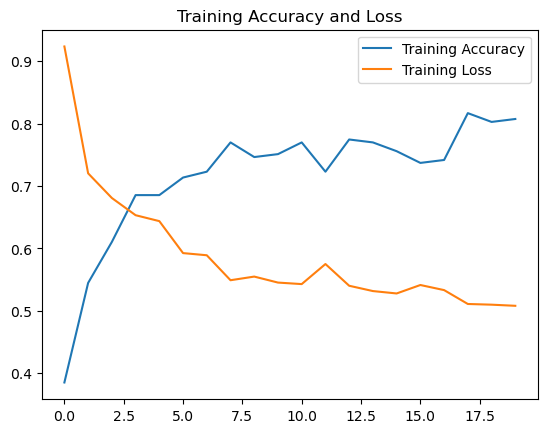

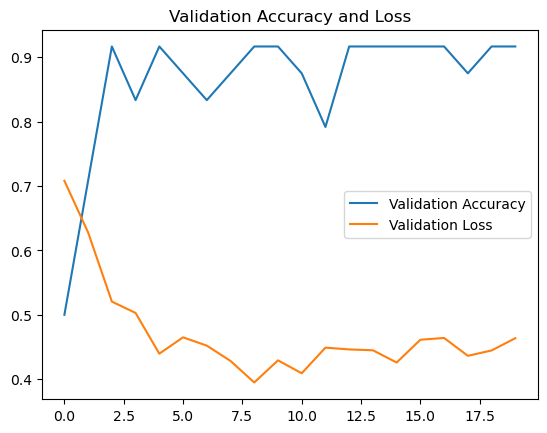

In [21]:
plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, loss, label='Training Loss')
plt.legend()
plt.title('Training Accuracy and Loss')

plt.figure()
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Validation Accuracy and Loss')

plt.show()

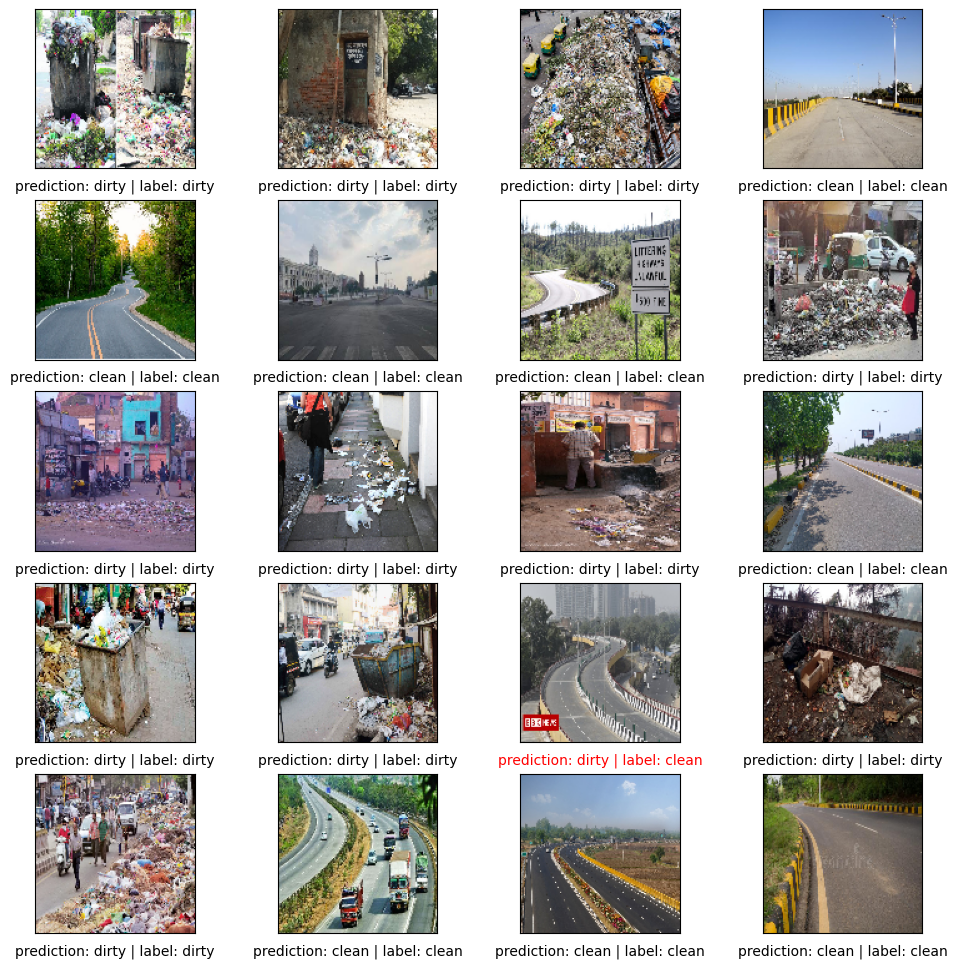

In [22]:
fig, axs = plt.subplots(5, 4, figsize=(12, 12))

i = 0
for x in range(5):
    for y in range(4):
        prediction = model.predict(X_val[i][None, ...], verbose=0)[0]
        
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        
        if np.argmax(prediction) != np.argmax(y_val[i]):   
            axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}', color='red')
        else:
            axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}')
        
        axs[x][y].imshow(X_val[i])
        
        i += 1
plt.show()

# Sources

- https://www.kaggle.com/code/crn4tww/clean-dirty-road-classification-accuracy-100
- https://www.kaggle.com/datasets/faizalkarim/cleandirty-road-classification
- https://www.kaggle.com/code/paultimothymooney/mobilenetv2-with-tensorflow